<a href="https://colab.research.google.com/github/gourav-prateek-sharma/Capstone-Project-COVER/blob/main/EXTRACTIONFUNCTIONS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt

# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

no_preview = True # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies

## Loading and Visualizing Scenes

Sionna RT can either load external scene files (in Mitsuba's XML file format) or it can load one of the [integrated scenes](https://nvlabs.github.io/sionna/rt/api/scene.html#examples).

In this example, we load an example scene containing the area around the Frauenkirche in Munich, Germany.

In [3]:
# Load integrated scene
scene = load_scene(sionna.rt.scene.munich) # Try also sionna.rt.scene.etoile

To visualize the scene, we can use the `preview` function which opens an interactive preview of the scene.
This only works in Jupyter notebooks.

You can use the following controls:

- Mouse left: Rotate
- Scroll wheel: Zoom
- Mouse right: Move

Please note that only one preview instance per scene can be opened at the same time.
However, multiple scenes can be loaded in parallel.

In [4]:
if not no_preview:
    scene.preview();

It is often convenient to choose a viewpoint in the 3D preview prior to rendering it as a high-quality image.
The next cell uses the "preview" camera which corresponds to the viewpoint of the current preview image.

In [5]:
# Only availabe if a preview is open
if not no_preview:
    scene.render(camera="preview", num_samples=512);

One can also render the image to a file as shown below:

In [6]:
# Only availabe if a preview is open
if not no_preview:
    scene.render_to_file(camera="preview",
                         filename="scene.png",
                         resolution=[650,500]);

Instead of the preview camera, one can also specify dedicated cameras with different positions and `look_at` directions.

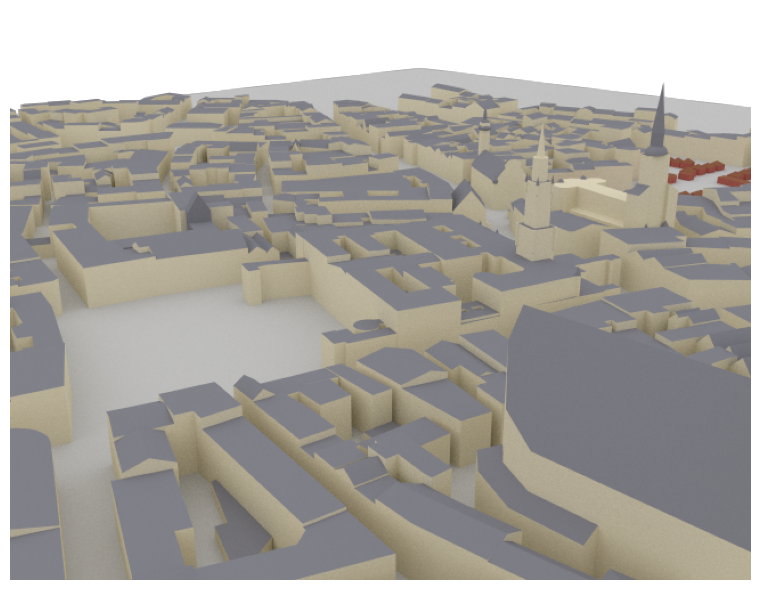

In [7]:
# Create new camera with different configuration
my_cam = Camera(position=[-250,250,150], look_at=[-15,30,28])

# Render scene with new camera*
scene.render(camera=my_cam, resolution=[650, 500], num_samples=512); # Increase num_samples to increase image quality

## Inspecting SceneObjects and Editing of Scenes

A scene consists of multiple [SceneObjects](https://nvlabs.github.io/sionna/rt/api/scene_object.html) which can be accessed in the following way:

In [8]:
scene = load_scene(sionna.rt.scene.simple_street_canyon, merge_shapes=False)
scene.objects

{'building_1': <sionna.rt.scene_object.SceneObject at 0x7ae8eca4de90>,
 'building_6': <sionna.rt.scene_object.SceneObject at 0x7ae8eca70890>,
 'building_5': <sionna.rt.scene_object.SceneObject at 0x7ae8eca61c50>,
 'building_4': <sionna.rt.scene_object.SceneObject at 0x7ae8eca61450>,
 'building_3': <sionna.rt.scene_object.SceneObject at 0x7ae8eca1e610>,
 'building_2': <sionna.rt.scene_object.SceneObject at 0x7ae8ec9fc1d0>,
 'floor': <sionna.rt.scene_object.SceneObject at 0x7ae93acb57d0>}

In [9]:
floor = scene.get("floor")

SceneObjects can be transformed by the following properties and methods:
- position
- orientation
- scaling
- look_at

In [10]:
print("Position (x,y,z) [m]: ", floor.position)
print("Orientation (alpha, beta, gamma) [rad]: ", floor.orientation)
print("Scaling: ", floor.scaling)

Position (x,y,z) [m]:  [[-0.769669, 0.238537, -0.0307941]]
Orientation (alpha, beta, gamma) [rad]:  [[0, 0, 0]]
Scaling:  [[1, 1, 1]]


More details on these functionalities can be found in the [Tutorial on Loading and Editing of Scenes](https://nvlabs.github.io/sionna/rt/tutorials/Scene-Edit.html).

Every SceneObject has another important property, the `velocity` vector:

In [11]:
print("Velocity (x,y,z) [m/s]: ", floor.velocity)

Velocity (x,y,z) [m/s]:  [[0, 0, 0]]


This property is used during the ray tracing process to compute a Doppler shift for every propagation path. This information can then be used to synthetically compute time evolution of channel impulse responses. More details on this topic are provided in the [Tutorial on Mobility](https://nvlabs.github.io/sionna/rt/tutorials/Mobility.html).

The last property of SceneObjects that we discuss here is the [RadioMaterial](https://nvlabs.github.io/sionna/rt/api/radio_materials.html):

In [12]:
floor.radio_material

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.123
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

The radio material determines how an object interacts with incident radio waves. To learn more about radio materials and how they can be modified, we invited you to have a look at the Developer Guide on [Understanding Radio Materials](https://nvlabs.github.io/sionna/rt/developer/dev_custom_radio_materials.html).

Depending on the type of radio material, some of its properties might change as a function of the frequency of the incident radio wave:

In [13]:
scene.frequency = 28e9 # in Hz; implicitly updates RadioMaterials that implement frequency dependent properties
floor.radio_material # Note that the conductivity (sigma) changes automatically

ITURadioMaterial type=concrete
                 eta_r=5.240
                 sigma=0.626
                 thickness=0.100
                 scattering_coefficient=0.000
                 xpd_coefficient=0.000

## Ray tracing of Propagation Paths

One a scene is loaded, we can place Transmitters and Receivers in it and compute propagation paths between them.
All transmitters and all receivers are equipped with the same antenna arrays which are defined by the `scene` properties `scene.tx_array` and `scene.rx_array`, respectively. Antenna arrays are composed of multiple identical antennas. Antennas can have custom or pre-defined patterns and are either single- or dual-polarized. One can add multiple transmitters and receivers to a scene which need to have unique names.

More details on antenna patterns can be found in the Developer Guide [Understanding Radio Materials](https://nvlabs.github.io/sionna/rt/developer/dev_custom_radio_materials.html).

In [14]:
scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge shapes to speed-up computations

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="tr38901",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross")

# Create transmitter
tx = Transmitter(name="tx",
                 position=[8.5,21,27],
                 display_radius=2)

# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name="rx",
              position=[45,90,1.5],
              display_radius=2)

# Add receiver instance to scene
scene.add(rx)

tx.look_at(rx) # Transmitter points towards receiver

Propagation paths are computed with the help of a [PathSolver](https://nvlabs.github.io/sionna/rt/api/paths_solvers.html).
The next cell shows how such a path solver is instantiated and used.

The parameter `max_depth` determines the maximum number of interactions between a ray and a scene objects.
For example, with a `max_depth` of zero, only LoS paths are considered For a `max_depth` of one, LoS as well as first-order reflections of refractions are considered.  When the argument `synthetic_array` is set to `False`, antenna arrays are explicitly modeled by finding paths between any pair of transmitting and receiving antennas in the scene. Otherwise, arrays are represented by a single antenna located in the center of the array.
Phase shifts related to the relative antenna positions will then be applied based on a plane-wave assumption when the channel impulse responses are computed.

In [15]:
# Instantiate a path solver
# The same path solver can be used with multiple scenes
p_solver  = PathSolver()

# Compute propagation paths
paths = p_solver(scene=scene,
                 max_depth=5,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

The [Paths](https://nvlabs.github.io/sionna/rt/paths.html) object contains all paths that have been found between transmitters and receivers.
In principle, the existence of each path is determininistic for a given position and environment. Please note that due to the stochastic nature of the *shoot-and-bounce* algorithm, different runs of the path solver can lead to different paths that are found. Most importantly, diffusely reflected paths are obtained through random sampling of directions after each interaction with a scene object. You can provide the `seed` argument to the solver to ensure reproducibility.

Let us now visualize the found paths in the scene:

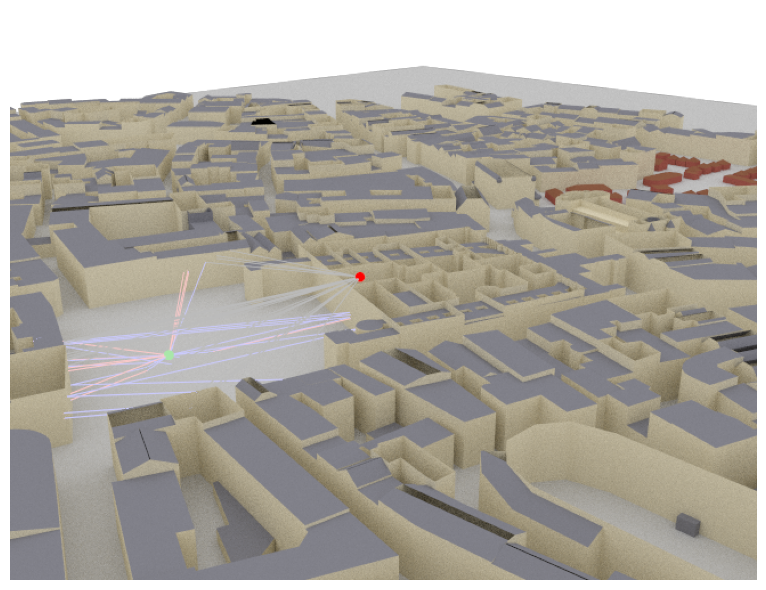

In [16]:
if no_preview:
    scene.render(camera=my_cam, paths=paths, clip_at=20);
else:
    scene.preview(paths=paths, clip_at=20);

The Paths object contains detailed information about every found path and allows us to generated channel impulse responses and apply Doppler shifts for the simulation of time evolution. For a detailed description, we refer to the developer guide [Understanding the Paths Object](https://nvlabs.github.io/sionna/rt/developer/dev_understanding_paths.html).

## Radio Maps

Sionna RT can compute radio maps for all transmitters in a scene. A [RadioMap](https://nvlabs.github.io/sionna/rt/api/radio_map.html) assigns a metric, such as path gain, received signal strength (RSS), or signal-to-interference-plus-noise ratio (SINR), for a specific transmitter to every point on a plane. In other words, for a given transmitter, it associates every point on a surface with the channel gain, RSS, or SINR, that a receiver with a specific orientation would observe at this point.

Like the computation of propagation paths requires a [PathSolver](https://nvlabs.github.io/sionna/rt/api/paths_solvers.html), the computation of radio maps requires a [RadioMapSolver](https://nvlabs.github.io/sionna/rt/api/radio_map_solvers.html). The following code snippet how a radio can be computed and displayed.

More information about radio maps can be found in the detailed [Tutorial on Radio Maps](https://nvlabs.github.io/sionna/rt/tutorials/Radio-Maps.html).

In [ ]:
rm_solver = RadioMapSolver()

rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6)

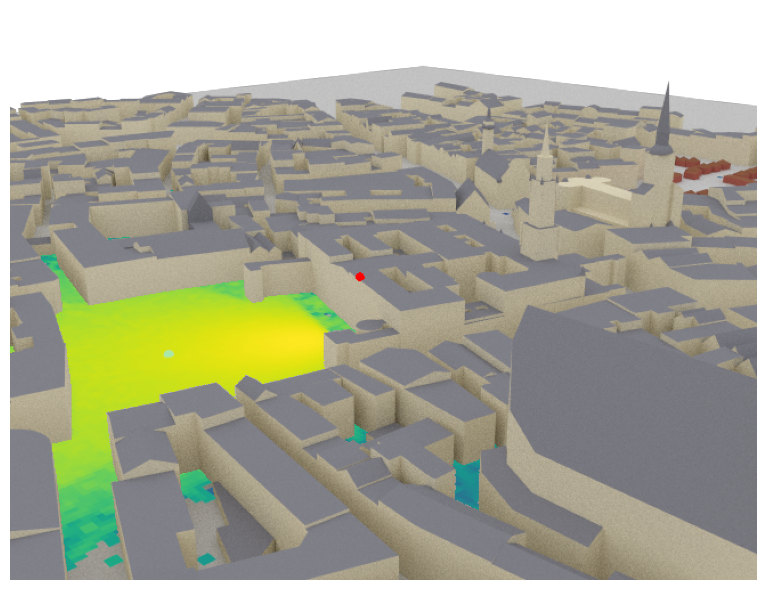

In [ ]:
if no_preview:
    scene.render(camera=my_cam, radio_map=rm);
else:
    scene.preview(radio_map=rm);

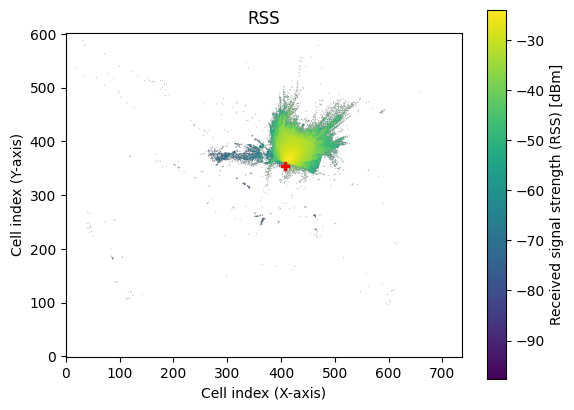

In [ ]:
rm.show(metric="rss");

In [ ]:
print(rm.path_gain)

[[[0, 0, 0, .. 732 skipped .., 0, 0, 0],
  [0, 0, 0, .. 732 skipped .., 0, 0, 0],
  [0, 0, 0, .. 732 skipped .., 0, 0, 0],
  .. 597 skipped ..,
  [0, 0, 0, .. 732 skipped .., 0, 0, 0],
  [0, 0, 0, .. 732 skipped .., 0, 0, 0],
  [0, 0, 0, .. 732 skipped .., 0, 0, 0]]]


RSS VALUE EXTRACTION FUNCTION

## This Python script provides utility functions to convert TensorFlow tensors or NumPy arrays into coordinate-based CSV files for easier analysis and visualization. It supports both 2D and 3D tensors by mapping each data point to its respective coordinates (x, y for 2D and z, x, y for 3D) along with its value. The tensor_to_coord_csv function exports all data points, while tensor_to_filtered_coord_csv allows filtering out zero values and optionally limits the number of rows using max_rows.

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from google.colab import files

def tensor_to_coord_csv(tensor, output_file="tensor_coord_data.csv"):

    # Convert tensor to numpy array
    if isinstance(tensor, tf.Tensor):
        numpy_array = tensor.numpy()
    else:
        numpy_array = np.array(tensor)

    original_shape = numpy_array.shape
    print(f"Original tensor shape: {original_shape}")

    if numpy_array.ndim == 2:
        rows, cols = numpy_array.shape
        coordinates = []

        for i in range(rows):
            for j in range(cols):
                coordinates.append((i, j, numpy_array[i, j]))

        df = pd.DataFrame(coordinates, columns=['x', 'y', 'value'])

    elif numpy_array.ndim == 3:
        depth, rows, cols = numpy_array.shape
        coordinates = []

        for d in range(depth):
            for i in range(rows):
                for j in range(cols):
                    coordinates.append((d, i, j, numpy_array[d, i, j]))

        df = pd.DataFrame(coordinates, columns=['z', 'x', 'y', 'value'])
        print(f"Created coordinate format with {len(coordinates)} points")

    else:
        flat_array = numpy_array.flatten()
        indices = np.arange(len(flat_array))
        df = pd.DataFrame({'index': indices, 'value': flat_array})
        print(f"Tensor has {numpy_array.ndim} dimensions, flattened to {len(flat_array)} values")


    df.to_csv(output_file, index=False)


    files.download(output_file)

    return f"Tensor saved to {output_file} in coordinate format"

def tensor_to_filtered_coord_csv(tensor, output_file="tensor_coord_filtered.csv", filter_zeros=True, max_rows=None):


    if isinstance(tensor, tf.Tensor):
        numpy_array = tensor.numpy()
    else:

        numpy_array = np.array(tensor)

    original_shape = numpy_array.shape
    print(f"Original tensor shape: {original_shape}")


    if numpy_array.ndim == 2:

        rows, cols = numpy_array.shape
        coordinates = []

        for i in range(rows):
            for j in range(cols):
                value = numpy_array[i, j]
                if not filter_zeros or value != 0:
                    coordinates.append((i, j, value))

        df = pd.DataFrame(coordinates, columns=['x', 'y', 'value'])

    elif numpy_array.ndim == 3:

        depth, rows, cols = numpy_array.shape
        coordinates = []

        for d in range(depth):
            for i in range(rows):
                for j in range(cols):
                    value = numpy_array[d, i, j]
                    if not filter_zeros or value != 0:
                        coordinates.append((d, i, j, value))

        df = pd.DataFrame(coordinates, columns=['z', 'x', 'y', 'value'])

    else:

        flat_array = numpy_array.flatten()
        indices = np.arange(len(flat_array))
        if filter_zeros:
            mask = flat_array != 0
            indices = indices[mask]
            flat_array = flat_array[mask]
        df = pd.DataFrame({'index': indices, 'value': flat_array})


    if max_rows is not None and len(df) > max_rows:
        df = df.sample(max_rows) if max_rows > 0 else df.head(max_rows)

    print(f"Created coordinate format with {len(df)} points")


    df.to_csv(output_file, index=False)

    files.download(output_file)

    return f"Tensor saved to {output_file} in coordinate format with {len(df)} points"

    result = tensor_to_filtered_coord_csv(rm.rss, filter_zeros=True, max_rows=1000000)
    print(result)

In [ ]:
print(type(rm.rss))

<class 'drjit.cuda.ad.TensorXf'>


rss_map_full

In [19]:
rm_solver = RadioMapSolver()

def rss_map_full(scene,max_depth,cell_size,samples_per_tx,write_csv):
    rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6)
    if write_csv:
        tensor_to_filtered_coord_csv(rm.rss)

rss_map_full(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6,write_csv="sample.csv")

Original tensor shape: (1, 603, 738)
Created coordinate format with 13456 points


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

rss_sample


In [22]:
rm_solver = RadioMapSolver()
def rss_sample(scene,max_depth,cell_size,samples_per_tx,write_csv):
    rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6)
    positions=rm.sample_cells(metric='rss',num_cells=200, min_val_db=-100.,
                                min_dist=50., max_dist=80.)

    tensor_to_filtered_coord_csv(positions)

rss_sample(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6,write_csv="sample.csv")

Original tensor shape: (1, 200)
Created coordinate format with 200 points


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

sinr_map_full()


In [23]:
rm_solver = RadioMapSolver()

def sinr_map_full(scene,max_depth,cell_size,samples_per_tx,write_csv):
    rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6)
    if write_csv:
        tensor_to_filtered_coord_csv(rm.sinr)

sinr_map_full(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6,write_csv="sample.csv")

Original tensor shape: (1, 603, 738)
Created coordinate format with 13456 points


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

sinr_sample()

In [25]:
rm_solver = RadioMapSolver()
def sinr_sample(scene,max_depth,cell_size,samples_per_tx,write_csv):
    rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6)
    positions=rm.sample_cells(metric='sinr',num_cells=200, min_val_db=-100.,
                                min_dist=50., max_dist=80.)

    tensor_to_filtered_coord_csv(positions)

sinr_sample(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6,write_csv="sample.csv")

Original tensor shape: (1, 200)
Created coordinate format with 200 points


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

path_gain_map_full()


In [26]:
rm_solver = RadioMapSolver()

def path_gain_map_full(scene,max_depth,cell_size,samples_per_tx,write_csv):
    rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6)
    if write_csv:
        tensor_to_filtered_coord_csv(rm.path_gain)

path_gain_map_full(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6,write_csv="sample.csv")

Original tensor shape: (1, 603, 738)
Created coordinate format with 13456 points


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

path_gain_samples()

In [27]:
rm_solver = RadioMapSolver()
def path_gain_sample(scene,max_depth,cell_size,samples_per_tx,write_csv):
    rm = rm_solver(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6)
    positions=rm.sample_cells(metric='path_gain',num_cells=200, min_val_db=-100.,
                                min_dist=50., max_dist=80.)

    tensor_to_filtered_coord_csv(positions)

path_gain_sample(scene=scene,
               max_depth=5,
               cell_size=[2,2],
               samples_per_tx=10**6,write_csv="sample.csv")

Original tensor shape: (1, 200)
Created coordinate format with 200 points


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>